# Preliminaries

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sys.path.append("/Users/paolo/Documents/methods/CMI_FS")
from feature_selection import forwardFeatureSelection

sys.path.append("/Users/paolo/Documents/methods/LinCFA")
from LinCFA import LinCFA

sys.path.append("/Users/paolo/Documents/methods/NonLinCFA")
from NonLinCFA import NonLinCFA

sys.path.append("/Users/paolo/Documents/Droughts/Paolo/regression_NonLinCFA")
from aux import standardize,unfold_dataset,compute_r2,prepare_target,prepare_features,aggregate_unfolded_data,aggregate_unfolded_data_onlyTrain,FS_with_linearWrapper,compare_methods, compute_r2


## Clusters of basins

In [17]:
### targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/csv_VHI/'
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_targets+basin+'.csv')
    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std

target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.010645    0.00  2001     1 -2.129508
1    2001-01-13  0.206769    0.00  2001     2 -0.927136
2    2001-01-21  0.267313    0.00  2001     3 -

In [18]:
### CMI best5 features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp
    

### Emiliani1 - Emiliani2 - Garda_Mincio: CMI best 5

In [19]:
### prova con Emiliani1 e 2 e Garda_Mincio
clust_basins = ['Emiliani1','Emiliani2','Garda_Mincio']
colnames = [x for x in best5_CMI_fulldf_train.columns if x.startswith('Emiliani1') or x.startswith('Emiliani2') or x.startswith('Garda_Mincio')]

clusterdf_train_withClass = pd.DataFrame()
clusterdf_val_withClass = pd.DataFrame()
clusterdf_test_withClass = pd.DataFrame()

for i in range(3):
    clusterdf_train_withClass = pd.concat((clusterdf_train_withClass,pd.concat((best5_CMI_fulldf_train[colnames],pd.DataFrame(1+i*np.ones(len(best5_CMI_fulldf_train)),columns=['basin'])),axis=1)),axis=0)
    clusterdf_val_withClass = pd.concat((clusterdf_val_withClass,pd.concat((best5_CMI_fulldf_val[colnames],pd.DataFrame(1+i*np.ones(len(best5_CMI_fulldf_val)),columns=['basin'])),axis=1)),axis=0)
    clusterdf_test_withClass = pd.concat((clusterdf_test_withClass,pd.concat((best5_CMI_fulldf_test[colnames],pd.DataFrame(1+i*np.ones(len(best5_CMI_fulldf_test)),columns=['basin'])),axis=1)),axis=0)

for i in range(3):
    clusterdf_train_withClass[clust_basins[i]] = clusterdf_train_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
    clusterdf_val_withClass[clust_basins[i]] = clusterdf_val_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
    clusterdf_test_withClass[clust_basins[i]] = clusterdf_test_withClass.apply(lambda x: int(x.basin==i+1),axis=1)

clusterdf_train_withClass = clusterdf_train_withClass.loc[:,clusterdf_train_withClass.columns != 'basin']
clusterdf_val_withClass = clusterdf_val_withClass.loc[:,clusterdf_val_withClass.columns != 'basin']
clusterdf_test_withClass = clusterdf_test_withClass.loc[:,clusterdf_test_withClass.columns != 'basin']


In [20]:
clusterdf_train_withClass[['Emiliani1_cyclostationary_mean_rr_4w_0','Emiliani2_cyclostationary_mean_tg_1w_4','Garda_Mincio_cyclostationary_mean_tg_8w_0','Emiliani1','Emiliani2','Garda_Mincio']].rename(columns={"Garda_Mincio": "Garda","Emiliani1_cyclostationary_mean_rr_4w_0":"Emiliani1_rr_4w_0","Emiliani2_cyclostationary_mean_tg_1w_4":"Emiliani2_tg_1w_4","Garda_Mincio_cyclostationary_mean_tg_8w_0":"Garda_tg_8w_0"})


,Emiliani1_rr_4w_0,Emiliani2_tg_1w_4,Garda_tg_8w_0,Emiliani1,Emiliani2,Garda
0,2.112078,-0.415835,0.523659,1,0,0
1,1.404523,0.237307,1.350980,1,0,0
2,1.162736,-0.259989,0.395851,1,0,0
3,0.861999,-0.565851,0.584992,1,0,0
4,1.461930,-0.187005,0.375705,1,0,0
...,...,...,...,...,...,...
406,-0.211596,1.352614,0.784844,0,0,1
407,-0.765747,1.040390,0.689576,0,0,1
408,-0.609296,0.830698,0.473678,0,0,1
409,-0.836849,-0.631908,-0.254712,0,0,1


In [21]:
targets_df_train_unfolded = pd.DataFrame()
targets_df_val_unfolded = pd.DataFrame()
targets_df_test_unfolded = pd.DataFrame()

for basin in ['Emiliani1','Emiliani2','Garda_Mincio']:
    targets_df_train_unfolded =  pd.concat((targets_df_train_unfolded,targets_df_train[basin]),axis=0)
    targets_df_val_unfolded =  pd.concat((targets_df_val_unfolded,targets_df_val[basin]),axis=0)
    targets_df_test_unfolded =  pd.concat((targets_df_test_unfolded,targets_df_test[basin]),axis=0)
targets_df_train_unfolded = targets_df_train_unfolded.reset_index(drop=True)
targets_df_val_unfolded = targets_df_val_unfolded.reset_index(drop=True)
targets_df_test_unfolded = targets_df_test_unfolded.reset_index(drop=True)


In [22]:
model_E1E2GM_ohe = LinearRegression()
model_E1E2GM_ohe.fit(pd.concat((clusterdf_train_withClass,clusterdf_val_withClass)),pd.concat((targets_df_train_unfolded,targets_df_val_unfolded)))

res = model_E1E2GM_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass.Emiliani1==1].values)
print(r2_score(targets_df_test['Emiliani1'].values, res))
res = model_E1E2GM_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass.Emiliani2==1].values)
print(r2_score(targets_df_test['Emiliani2'].values, res))
res = model_E1E2GM_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass.Garda_Mincio==1].values)
print(r2_score(targets_df_test['Garda_Mincio'].values, res))


0.4031090822249196
0.3100764945337041
0.28477623168379707


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Tigramite

In [23]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS 
#from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

In [10]:
clusterdf_trainVal = pd.concat((clusterdf_train_withClass.iloc[0:411,:-3],clusterdf_val_withClass.iloc[0:228,:-3]))
targets_df_trainVal = pd.concat((targets_df_train[['Emiliani1','Emiliani2','Garda_Mincio']],targets_df_val[['Emiliani1','Emiliani2','Garda_Mincio']]))
clusterdf_trainVal_withTarget = pd.concat((clusterdf_trainVal.reset_index(drop=True),targets_df_trainVal.reset_index(drop=True)),axis=1)
    

In [9]:
def PCMCI_singleBasin(variables,tau=0,cond_test=ParCorr()):    
    clusterdf_trainVal = pd.concat((clusterdf_train_withClass.iloc[0:411,:-3],clusterdf_val_withClass.iloc[0:228,:-3]))
    targets_df_trainVal = pd.concat((targets_df_train[['Emiliani1','Emiliani2','Garda_Mincio']],targets_df_val[['Emiliani1','Emiliani2','Garda_Mincio']]))
    clusterdf_trainVal_withTarget = pd.concat((clusterdf_trainVal.reset_index(drop=True),targets_df_trainVal.reset_index(drop=True)),axis=1)
    
    dataframe = pp.DataFrame(clusterdf_trainVal_withTarget.loc[:,variables].values)
    
    cond_ind_test = cond_test
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    results = pcmci.run_pcmciplus(tau_max=tau, pc_alpha=0.01)
    #results = pcmci.run_pcmci(tau_max=tau, pc_alpha=0.01)

    pcmci.print_significant_links(p_matrix=results['p_matrix'],val_matrix=results['val_matrix'])
    
    tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=list(variables),
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    )
    plt.show()
    
    tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=list(variables),
    link_colorbar_label='MCI',
    )
    plt.show()
    


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (3  0): pval = 0.00000 | val =  0.579
        (5  0): pval = 0.00000 | val =  0.256
        (2  0): pval = 0.00000 | val =  0.239

    Variable 1 has 2 link(s):
        (4  0): pval = 0.00000 | val =  0.749
        (3  0): pval = 0.03053 | val = -0.086

    Variable 2 has 3 link(s):
        (3  0): pval = 0.00000 | val =  0.247
        (0  0): pval = 0.00000 | val =  0.239
        (5  0): pval = 0.00000 | val =  0.190

    Variable 3 has 3 link(s):
        (0  0): pval = 0.00000 | val =  0.579
        (2  0): pval = 0.00000 | val =  0.247
        (1  0): pval = 0.03053 | val = -0.086

    Variable 4 has 2 link(s):
        (1  0): pval = 0.00000 | val =  0.749
        (5  0): pval = 0.00034 | val = -0.142

    Variable 5 has 3 link(s):
        (0  0): pval = 0.00000 | val =  0.256
        (2  0): pval = 0.00000 | val =  0.190
        (4  0): pval = 0.00034 | val = -0.142


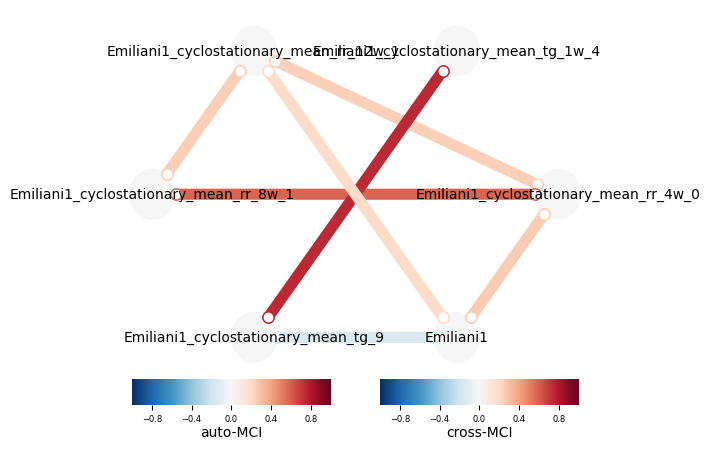

/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tigramite/plotting.py:3246: RuntimeWarning: invalid value encountered in double_scalars
  ((i % max_lag) - posarray.min(axis=0)[0])


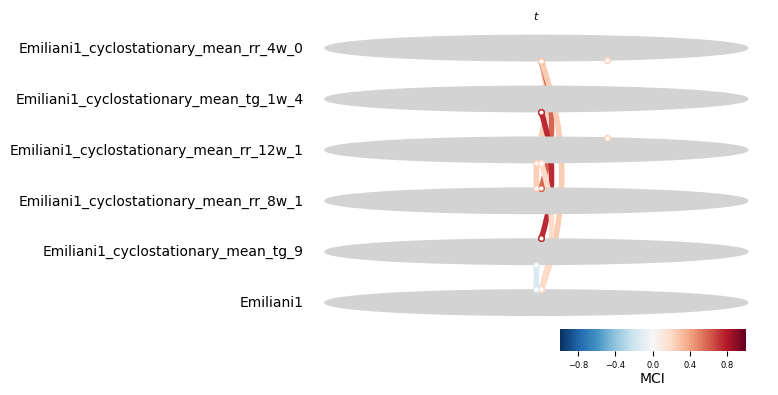

In [11]:
variables = ['Emiliani1_cyclostationary_mean_rr_4w_0','Emiliani1_cyclostationary_mean_tg_1w_4','Emiliani1_cyclostationary_mean_rr_12w_1','Emiliani1_cyclostationary_mean_rr_8w_1','Emiliani1_cyclostationary_mean_tg_9','Emiliani1']

PCMCI_singleBasin(variables)



## Significant links at alpha = 0.05:

    Variable 0 has 6 link(s):
        (0 -1): pval = 0.00000 | val =  0.578
        (3  0): pval = 0.00000 | val =  0.503
        (2  0): pval = 0.00000 | val =  0.268
        (5  0): pval = 0.00002 | val =  0.170
        (1  0): pval = 0.01133 | val = -0.101
        (2 -1): pval = 0.03632 | val =  0.083

    Variable 1 has 8 link(s):
        (4  0): pval = 0.00000 | val =  0.830
        (4 -1): pval = 0.00000 | val =  0.361
        (1 -1): pval = 0.00000 | val =  0.339
        (5  0): pval = 0.00010 | val = -0.154
        (0  0): pval = 0.01133 | val = -0.101
        (0 -1): pval = 0.01676 | val = -0.095
        (2 -1): pval = 0.02630 | val = -0.088
        (3  0): pval = 0.03804 | val = -0.083

    Variable 2 has 5 link(s):
        (2 -1): pval = 0.00000 | val =  0.634
        (0  0): pval = 0.00000 | val =  0.268
        (5  0): pval = 0.00264 | val =  0.119
        (4 -1): pval = 0.01984 | val = -0.092
        (0 -1): pval = 0.03411 | val =  

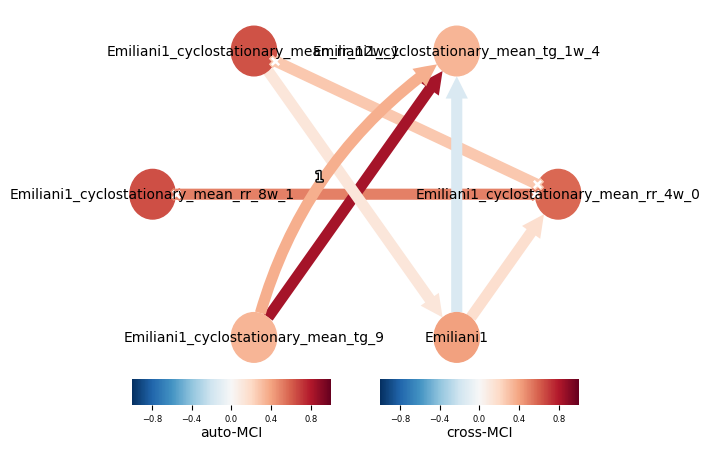

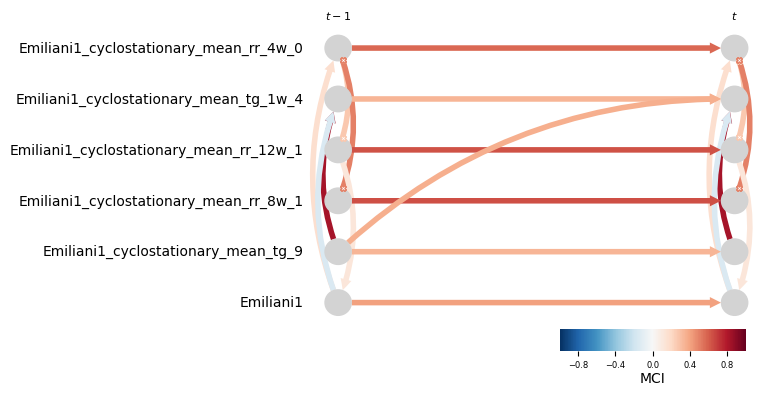

In [12]:
variables = ['Emiliani1_cyclostationary_mean_rr_4w_0','Emiliani1_cyclostationary_mean_tg_1w_4','Emiliani1_cyclostationary_mean_rr_12w_1','Emiliani1_cyclostationary_mean_rr_8w_1','Emiliani1_cyclostationary_mean_tg_9','Emiliani1']

PCMCI_singleBasin(variables,tau=1)



## Significant links at alpha = 0.05:

    Variable 0 has 4 link(s):
        (2  0): pval = 0.00000 | val =  0.114
        (3  0): pval = 0.00000 | val =  0.086
        (5  0): pval = 0.00000 | val =  0.033
        (1  0): pval = 0.04600 | val =  0.015

    Variable 1 has 3 link(s):
        (4  0): pval = 0.00000 | val =  0.271
        (2  0): pval = 0.03000 | val =  0.024
        (0  0): pval = 0.04600 | val =  0.015

    Variable 2 has 3 link(s):
        (0  0): pval = 0.00000 | val =  0.114
        (3  0): pval = 0.00000 | val =  0.048
        (1  0): pval = 0.03000 | val =  0.024

    Variable 3 has 4 link(s):
        (0  0): pval = 0.00000 | val =  0.086
        (2  0): pval = 0.00000 | val =  0.048
        (5  0): pval = 0.00000 | val =  0.026
        (4  0): pval = 0.04200 | val =  0.016

    Variable 4 has 3 link(s):
        (1  0): pval = 0.00000 | val =  0.271
        (5  0): pval = 0.00000 | val =  0.024
        (3  0): pval = 0.04200 | val =  0.016

    Variable 5 has 3 li

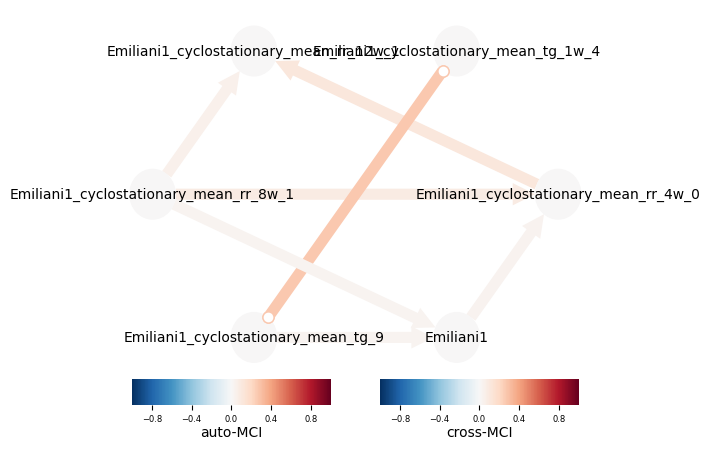

/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tigramite/plotting.py:3246: RuntimeWarning: invalid value encountered in double_scalars
  ((i % max_lag) - posarray.min(axis=0)[0])


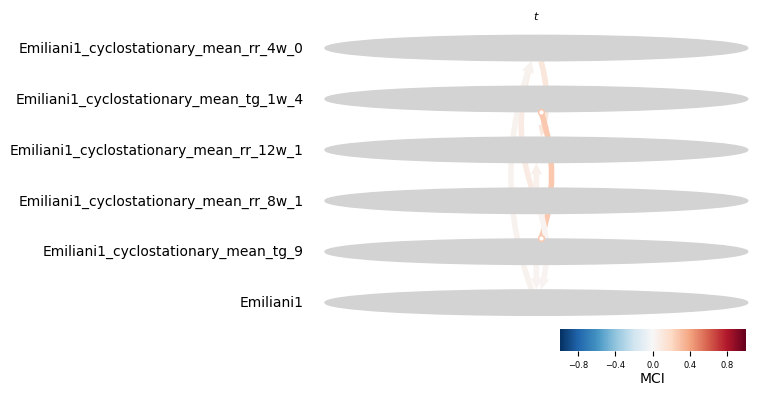

In [14]:
variables = ['Emiliani1_cyclostationary_mean_rr_4w_0','Emiliani1_cyclostationary_mean_tg_1w_4','Emiliani1_cyclostationary_mean_rr_12w_1','Emiliani1_cyclostationary_mean_rr_8w_1','Emiliani1_cyclostationary_mean_tg_9','Emiliani1']

PCMCI_singleBasin(variables,tau=0,cond_test=CMIknn())



## Significant links at alpha = 0.05:

    Variable 0 has 8 link(s):
        (0 -1): pval = 0.00000 | val =  0.028
        (3  0): pval = 0.00000 | val =  0.018
        (5  0): pval = 0.00400 | val =  0.015
        (5 -1): pval = 0.01600 | val =  0.014
        (1 -1): pval = 0.01800 | val =  0.013
        (2  0): pval = 0.00000 | val =  0.013
        (4  0): pval = 0.03600 | val =  0.009
        (1  0): pval = 0.02400 | val =  0.008

    Variable 1 has 6 link(s):
        (4 -1): pval = 0.00000 | val =  0.123
        (4  0): pval = 0.00000 | val =  0.115
        (2 -1): pval = 0.05000 | val =  0.023
        (3 -1): pval = 0.04200 | val =  0.023
        (0 -1): pval = 0.01200 | val =  0.014
        (0  0): pval = 0.02400 | val =  0.008

    Variable 2 has 4 link(s):
        (2 -1): pval = 0.00000 | val =  0.100
        (1 -1): pval = 0.01400 | val =  0.025
        (0  0): pval = 0.00000 | val =  0.013
        (3  0): pval = 0.02600 | val =  0.008

    Variable 3 has 5 link(s):
        (

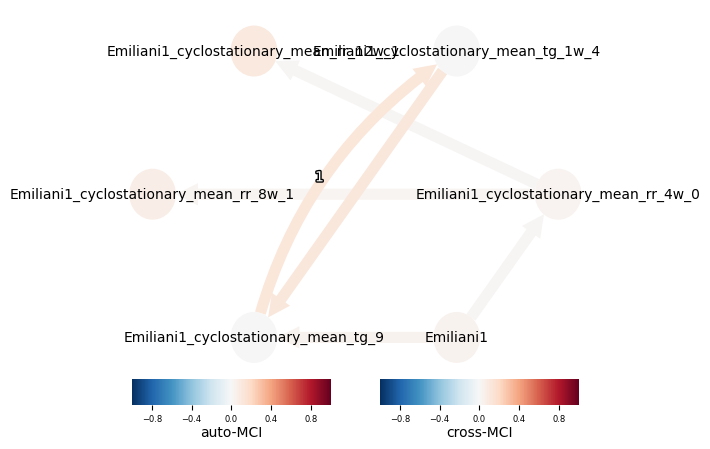

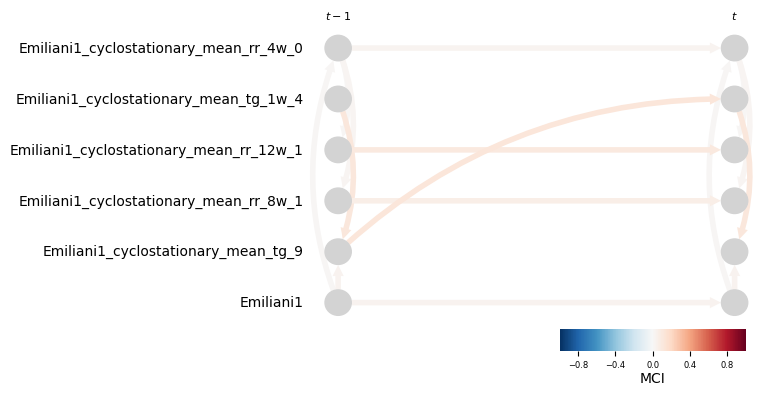

In [13]:
variables = ['Emiliani1_cyclostationary_mean_rr_4w_0','Emiliani1_cyclostationary_mean_tg_1w_4','Emiliani1_cyclostationary_mean_rr_12w_1','Emiliani1_cyclostationary_mean_rr_8w_1','Emiliani1_cyclostationary_mean_tg_9','Emiliani1']

PCMCI_singleBasin(variables,tau=1,cond_test=CMIknn())


## CMI

In [25]:
clusterdf_trainVal_withTarget

,Emiliani1_cyclostationary_mean_rr_4w_0,Emiliani1_cyclostationary_mean_tg_1w_4,Emiliani1_cyclostationary_mean_rr_12w_1,Emiliani1_cyclostationary_mean_rr_8w_1,Emiliani1_cyclostationary_mean_tg_9,Emiliani2_cyclostationary_mean_tg_1w_4,Emiliani2_cyclostationary_mean_rr_4w_3,Emiliani2_cyclostationary_mean_tg_4,Emiliani2_cyclostationary_mean_rr_8w_0,Emiliani2_cyclostationary_mean_rr_12w_1,Garda_Mincio_cyclostationary_mean_rr_4w_0,Garda_Mincio_cyclostationary_mean_tg_0,Garda_Mincio_cyclostationary_mean_rr_8w_0,Garda_Mincio_cyclostationary_mean_rr_12w_2,Garda_Mincio_cyclostationary_mean_tg_8w_0,Emiliani1,Emiliani2,Garda_Mincio
0,2.112078,0.345989,1.690770,3.965287,0.268224,-0.415835,0.733822,-0.736407,2.581050,1.579481,1.154090,0.309939,1.365733,1.718220,0.523659,-0.382765,-1.339879,-1.996014
1,1.404523,1.128851,1.865833,1.655892,0.977612,0.237307,0.849889,0.294888,2.460299,1.146518,1.494420,1.158323,1.161450,3.292752,1.350980,0.319215,0.402993,0.498869
2,1.162736,0.786460,1.429151,1.672157,-0.780151,-0.259989,0.518355,-1.191392,1.657472,0.697926,0.992024,-0.747849,0.765542,2.143920,0.395851,0.548542,0.282703,-0.428613
3,0.861999,0.564161,0.611897,1.593990,0.408553,-0.565851,0.239497,0.067063,1.600489,0.578318,0.831685,0.618235,0.486500,2.057757,0.584992,-0.010351,-0.030490,-0.583432
4,1.461930,0.604584,4.150391,1.782496,-0.260577,-0.187005,0.696217,-0.894857,1.249495,0.843396,0.648410,-0.197356,0.471393,1.411145,0.375705,0.402030,0.451097,0.075938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,-0.608772,2.159366,1.128914,0.745100,0.624547,2.050920,1.182447,0.848215,1.287369,0.181394,-0.118561,0.720331,-0.181497,0.130180,1.825689,-0.320516,-0.229575,0.018152
635,-0.325822,1.311011,0.790244,0.037201,1.691934,1.776750,1.931919,1.300383,1.500711,0.244831,0.385108,1.882524,-0.187245,-0.019638,2.096129,0.137056,0.038989,0.313402
636,0.588081,1.354429,1.428052,0.170754,1.924323,1.963611,2.777644,1.044000,1.878066,0.317723,1.208375,1.802134,0.370318,0.092279,2.438950,0.305368,0.020677,0.293271
637,0.360721,1.653467,1.152108,0.094855,1.546077,1.734032,2.563059,1.124935,1.799993,0.278011,0.952668,1.588204,0.253557,-0.003589,2.661555,-0.586199,-0.444088,-0.217675


In [24]:
sys.path.append("/Users/paolo/Documents/methods/CMI_FS")

from mixedRVMI import CMIEstimate,MIEstimate

In [17]:
variables = ['Emiliani1_cyclostationary_mean_rr_4w_0','Emiliani1_cyclostationary_mean_tg_1w_4','Emiliani1_cyclostationary_mean_rr_12w_1','Emiliani1_cyclostationary_mean_rr_8w_1','Emiliani1_cyclostationary_mean_tg_9']
print(CMIEstimate(clusterdf_trainVal_withTarget.iloc[1:].Emiliani1.values,clusterdf_trainVal_withTarget[variables].iloc[1:].values,clusterdf_trainVal_withTarget.iloc[:-1].Emiliani1.values))

for var in variables:
    print(var,CMIEstimate(clusterdf_trainVal_withTarget.iloc[1:].Emiliani1.values,clusterdf_trainVal_withTarget[var].iloc[1:].values,clusterdf_trainVal_withTarget.iloc[:-1].Emiliani1.values))
    

0.12939687750675055
Emiliani1_cyclostationary_mean_rr_4w_0 0.05325919981913266
Emiliani1_cyclostationary_mean_tg_1w_4 0.03727768505064449
Emiliani1_cyclostationary_mean_rr_12w_1 0.012860180015807438
Emiliani1_cyclostationary_mean_rr_8w_1 0.03338659908193789
Emiliani1_cyclostationary_mean_tg_9 0.043076525073516586


In [18]:
for var in variables:
    print(var,CMIEstimate(clusterdf_trainVal_withTarget.iloc[1:].Emiliani1.values,clusterdf_trainVal_withTarget[var].iloc[1:].values,pd.concat((clusterdf_trainVal_withTarget.iloc[:-1].Emiliani1.reset_index(drop=True),clusterdf_trainVal_withTarget.iloc[1:].Emiliani1_cyclostationary_mean_rr_4w_0.reset_index(drop=True)),axis=1).values))


Emiliani1_cyclostationary_mean_rr_4w_0 -0.7787921396129096
Emiliani1_cyclostationary_mean_tg_1w_4 0.021892943717492258
Emiliani1_cyclostationary_mean_rr_12w_1 -0.01944493617701401
Emiliani1_cyclostationary_mean_rr_8w_1 0.019307240142825255
Emiliani1_cyclostationary_mean_tg_9 0.06807187487565355


In [19]:
for var in variables:
    print(var,CMIEstimate(clusterdf_trainVal_withTarget.iloc[1:].Emiliani1.values,clusterdf_trainVal_withTarget[var].iloc[1:].values,pd.concat((clusterdf_trainVal_withTarget.iloc[:-1].Emiliani1.reset_index(drop=True),clusterdf_trainVal_withTarget.iloc[1:].loc[:,['Emiliani1_cyclostationary_mean_rr_4w_0','Emiliani1_cyclostationary_mean_tg_9']].reset_index(drop=True)),axis=1).values))
  

Emiliani1_cyclostationary_mean_rr_4w_0 -0.34416143416119227
Emiliani1_cyclostationary_mean_tg_1w_4 -0.02008976011906738
Emiliani1_cyclostationary_mean_rr_12w_1 -0.02795417006073364
Emiliani1_cyclostationary_mean_rr_8w_1 -0.034201516047272174
Emiliani1_cyclostationary_mean_tg_9 -0.3543563427156897


In [ ]:
#Emiliani1_cyclostationary_mean_rr_4w_0,Emiliani1_cyclostationary_mean_tg_9

In [22]:
clusterdf_trainVal_withTarget.to_csv('/Users/paolo/Downloads/mirror-kde-master/droughts_E1E2GMcluster.csv')

In [35]:
clusterdf_trainVal_withTarget

,Emiliani1_cyclostationary_mean_rr_4w_0,Emiliani1_cyclostationary_mean_tg_1w_4,Emiliani1_cyclostationary_mean_rr_12w_1,Emiliani1_cyclostationary_mean_rr_8w_1,Emiliani1_cyclostationary_mean_tg_9,Emiliani2_cyclostationary_mean_tg_1w_4,Emiliani2_cyclostationary_mean_rr_4w_3,Emiliani2_cyclostationary_mean_tg_4,Emiliani2_cyclostationary_mean_rr_8w_0,Emiliani2_cyclostationary_mean_rr_12w_1,Garda_Mincio_cyclostationary_mean_rr_4w_0,Garda_Mincio_cyclostationary_mean_tg_0,Garda_Mincio_cyclostationary_mean_rr_8w_0,Garda_Mincio_cyclostationary_mean_rr_12w_2,Garda_Mincio_cyclostationary_mean_tg_8w_0,Emiliani1,Emiliani2,Garda_Mincio
0,2.112078,0.345989,1.690770,3.965287,0.268224,-0.415835,0.733822,-0.736407,2.581050,1.579481,1.154090,0.309939,1.365733,1.718220,0.523659,-0.382765,-1.339879,-1.996014
1,1.404523,1.128851,1.865833,1.655892,0.977612,0.237307,0.849889,0.294888,2.460299,1.146518,1.494420,1.158323,1.161450,3.292752,1.350980,0.319215,0.402993,0.498869
2,1.162736,0.786460,1.429151,1.672157,-0.780151,-0.259989,0.518355,-1.191392,1.657472,0.697926,0.992024,-0.747849,0.765542,2.143920,0.395851,0.548542,0.282703,-0.428613
3,0.861999,0.564161,0.611897,1.593990,0.408553,-0.565851,0.239497,0.067063,1.600489,0.578318,0.831685,0.618235,0.486500,2.057757,0.584992,-0.010351,-0.030490,-0.583432
4,1.461930,0.604584,4.150391,1.782496,-0.260577,-0.187005,0.696217,-0.894857,1.249495,0.843396,0.648410,-0.197356,0.471393,1.411145,0.375705,0.402030,0.451097,0.075938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,-0.608772,2.159366,1.128914,0.745100,0.624547,2.050920,1.182447,0.848215,1.287369,0.181394,-0.118561,0.720331,-0.181497,0.130180,1.825689,-0.320516,-0.229575,0.018152
635,-0.325822,1.311011,0.790244,0.037201,1.691934,1.776750,1.931919,1.300383,1.500711,0.244831,0.385108,1.882524,-0.187245,-0.019638,2.096129,0.137056,0.038989,0.313402
636,0.588081,1.354429,1.428052,0.170754,1.924323,1.963611,2.777644,1.044000,1.878066,0.317723,1.208375,1.802134,0.370318,0.092279,2.438950,0.305368,0.020677,0.293271
637,0.360721,1.653467,1.152108,0.094855,1.546077,1.734032,2.563059,1.124935,1.799993,0.278011,0.952668,1.588204,0.253557,-0.003589,2.661555,-0.586199,-0.444088,-0.217675


In [36]:
print(CMIEstimate(clusterdf_trainVal_withTarget.Emiliani1_cyclostationary_mean_rr_4w_0.values,clusterdf_trainVal_withTarget.Emiliani1_cyclostationary_mean_tg_1w_4.values,clusterdf_trainVal_withTarget.Emiliani1_cyclostationary_mean_rr_12w_1.values))


0.017693000442049106
